In [ ]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 35.5 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 212 kB 70.8 MB/s 
     |████████████████████████████████| 253 kB 68.6 MB/s 
     |████████████████████████████████| 53 kB 2.9 MB/s 
     |████████████████████████████████| 2.0 MB 46.9 MB/s 
     |████████████████████████████████| 1.1 MB 68.5 MB/s 
     |████████████████████████████████| 144 kB 71.1 MB/s 
     |████████████████████████████████| 271 kB 72.7 MB/s 
     |████████████████████████████████| 94 kB 4.8 MB/s 
     |████████████████████████████████| 11.1 MB 57.0 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 80 kB 11.9 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 4.0

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 24.9 MB/s 


**Admin panel**

In [ ]:
import requests

import gradio as gr
import torch
from timm import create_model
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

IMAGENET_1k_URL = "https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')
model = create_model('resnet50', pretrained=True)

transform = create_transform(
    **resolve_data_config({}, model=model)
)
model.eval()
def predict_fn(img):
    img = img.convert('RGB')
    print(img)
    img = transform(img).unsqueeze(0)

    with torch.no_grad():
        out = model(img)
    
    probabilites = torch.nn.functional.softmax(out[0], dim=0)

    values, indices = torch.topk(probabilites, k=5)
  
    return {LABELS[i]: v.item() for i, v in zip(indices, values)}
  
gr.Interface(predict_fn, gr.inputs.Image(type='pil'), outputs='label').launch()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://30716.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7efd885c2410>,
 'http://127.0.0.1:7860/',
 'https://30716.gradio.app')

In [ ]:
print(len(LABELS))

1000


In [ ]:
# Imports

import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import shutil # high-level operations on files
from tqdm import tqdm # Progress bar and status logging
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

import cv2 # computer vision algorithms

# Importing the Keras libraries and packages
from keras import utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Configuration

DATASET_DIR = '/content/gdrive/MyDrive/real_and_fake_face'
TRAIN_DIR = '/content/gdrive/MyDrive/train_dataset'
TEST_DIR = '/content/gdrive/MyDrive/test_dataset'

RATE = 0.2 # splitting proportion for training and test datasets

# Parameters for Grid Search

N_EPOCHS = [20] #[20, 40, 100, 200]
OPTIMIZERS = ['adam'] #['adam', 'rmsprop', 'SGD']
DROPOUT_RATES =  [0.1, 0.2, 0.4]
LOSS_FUNCTIONS = ['binary_crossentropy']  #['sparse_categorical_crossentropy', 'kullback_leibler_divergence']    

In [ ]:
os.mkdir(TRAIN_DIR)
os.mkdir(TRAIN_DIR+'/fake')
os.mkdir(TRAIN_DIR+'/real')

os.mkdir(TEST_DIR)
os.mkdir(TEST_DIR+'/fake')
os.mkdir(TEST_DIR+'/real')

FileExistsError: ignored

Updated folder structure:

In [ ]:
# Split folders with images into training, validation and test folders.
# OPTION 1 (using split-folders)

#pip install split-folders

#import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#split_folders.ratio('input_folder', output="output", seed=1337, ratio=(.8, .1, .1)) # default values


In [ ]:
# Split image files into test and training set 
# OPTION 2 (copying files into newly created folders)
files_real = os.listdir(f'{DATASET_DIR}/training_real')
files_fake = os.listdir(f'{DATASET_DIR}/training_fake')


# sample from each class to create a test set
np.random.seed(0)
files_real_test = np.random.choice(
    files_real,
    size=round(len(files_real) * RATE),
    replace=False,
    p=None)

files_real_train = list(set(files_real) - set(files_real_test)) #[file for file in files_real if file not in files_real_test] 

files_fake_test = np.random.choice(
    files_fake,
    size=round(len(files_fake) * RATE),
    replace=False,
    p=None)

files_fake_train = list(set(files_fake) - set(files_fake_test)) #[file for file in files_fake if file not in files_fake_test] 

for file in files_real_train:
    shutil.copyfile(DATASET_DIR+'/training_real/'+file, TRAIN_DIR+'/real/'+file) 

for file in files_fake_train:
    shutil.copyfile(DATASET_DIR+'/training_fake/'+file, TRAIN_DIR+'/fake/'+file) 

for file in files_real_test:
    shutil.copyfile(DATASET_DIR+'/training_real/'+file, TEST_DIR+'/real/'+file) 

for file in files_fake_test:
    shutil.copyfile(DATASET_DIR+'/training_fake/'+file, TEST_DIR+'/fake/'+file) 
    

In [ ]:
train_samples = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
test_samples = sum([len(files) for r, d, files in os.walk(TEST_DIR)])
print('Number of training images: {} \nNumber of test images: {}'.format(train_samples, test_samples))

Number of training images: 3694 
Number of test images: 923


In [ ]:
# load and show an image with Pillow
# from PIL import Image
# image = Image.open('/kaggle/test_dataset/fake/hard_39_1111.jpg')
# # some details about the image
# print(image.format)
# print(image.mode)
# print(image.size)

In [ ]:

def get_images(path, img_shape=(64, 64)):
 
    '''
    Returns a np array of images and labels from path
    Images must be stored in path/class1, path/class2
    '''
    main_path = path
    y = []
    list = [name for name in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, name))]
    print(list)
    image_collection = []
    for idx,folder in enumerate(list):
 
        label = idx
        
        sub_list = sorted(os.listdir(os.path.join(main_path,folder)))
 
        for i in tqdm(range(1, len(sub_list))):
            image_path = os.path.join(main_path, folder, sub_list[i])
            read_image = cv2.imread(image_path)
            try:
              image_resized = cv2.resize(read_image, img_shape, interpolation=cv2.INTER_AREA)
            except:
              continue
            image = np.float32(image_resized)
            image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #Change alpha, beta according to the preprocessing you desire
            
            image_collection.append(image)
            
            y.append(label)
 
    y = np.array(y)
    y = tf.keras.utils.to_categorical(y,num_classes=len(list))
 
    return image_collection, y[:,0] 


In [ ]:
import tensorflow as tf
# Preparing test and trainng datasets
X_train,y_train = get_images(TRAIN_DIR,img_shape=(64,64))
X_test,y_test = get_images(TEST_DIR,img_shape=(64,64))
X_train = np.array(X_train)
X_test = np.array(X_test)
# print(X_train.shape)
# print(X_train[0])
# from PIL import Image
# im = Image.fromarray(X_train[0].astype('uint8'))
# im.save("img50.jpg")


['fake', 'real']


100%|██████████| 1097/1097 [01:11<00:00, 15.37it/s]


['fake', 'real']


100%|██████████| 273/273 [00:14<00:00, 19.45it/s]


In [ ]:
print('Training set', X_train.shape)
print('Test set', X_test.shape)

Training set (3689, 64, 64, 3)
Test set (921, 64, 64, 3)


We don't have too much data to train the network. 
One of possible workarounds is to use ImageDataGenerator.
On the one hand, it does allow us to generate additional examples. On the other hand, all of these examples are based on a too small dataset and the network still cannot generalize to data it was never trained on 


In [ ]:
#Shuffle training examples
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
def build_classifier(optimizer, dropout, loss):
    classifier = Sequential()
    classifier.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    classifier.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    classifier.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    classifier.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    classifier.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    classifier.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    classifier.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    classifier.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    classifier.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    classifier.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    classifier.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    classifier.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    classifier.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    classifier.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    classifier.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    classifier.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    classifier.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    classifier.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    classifier.add(Flatten())
    classifier.add(Dense(units=4096,activation="relu"))
    classifier.add(Dense(units=4096,activation="relu"))
    classifier.add(Dense(units=2, activation="softmax"))
    
    classifier.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])    

    return classifier


classifier = KerasClassifier(build_fn = build_classifier)

grid_parameters = {'epochs': N_EPOCHS,
                  'optimizer': OPTIMIZERS,
                  'dropout': DROPOUT_RATES,                  
                  'loss':LOSS_FUNCTIONS                        
                  }


grid_search = GridSearchCV(estimator = classifier,
                           param_grid = grid_parameters,
                           scoring = 'accuracy',
                           cv = 10)


grid_search = grid_search.fit(X_train, y_train, verbose=0)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: User

In [ ]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(best_parameters)
print(best_accuracy)

{'dropout': 0.1, 'epochs': 20, 'loss': 'binary_crossentropy', 'optimizer': 'adam'}
0.7031680805938494


# New Section

In [ ]:
predicted = grid_search.predict(X_test)

Confusion matrix for training set:


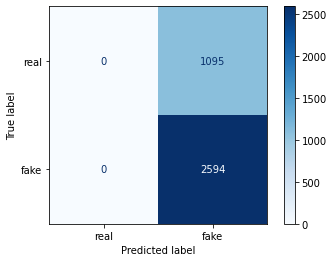

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1095
         1.0       0.70      1.00      0.83      2594

    accuracy                           0.70      3689
   macro avg       0.35      0.50      0.41      3689
weighted avg       0.49      0.70      0.58      3689

Confusion matrix  for test set:


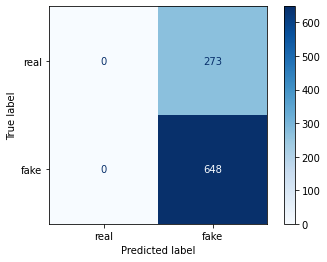




              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       273
         1.0       0.70      1.00      0.83       648

    accuracy                           0.70       921
   macro avg       0.35      0.50      0.41       921
weighted avg       0.50      0.70      0.58       921



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print('Confusion matrix for training set:')
labels = ["real", "fake"]
train_mat = confusion_matrix(y_train,grid_search.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=train_mat, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

print()
print('\n')
print(classification_report(y_train,grid_search.predict(X_train)))

print('Confusion matrix  for test set:')
test_mat = confusion_matrix(y_test,predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=test_mat, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()
print()
print('\n')
print(classification_report(y_test,predicted))

In [ ]:
import matplotlib.pyplot as plt
import numpy

def history():
    classifier = Sequential() # Initialising the CNN    
    classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')) 
    classifier.add(MaxPooling2D(pool_size = (2, 2))) 
    
    classifier.add(Conv2D(32, (3, 3), activation = 'relu'))  
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
  
    classifier.add(Conv2D(32, (3, 3), activation = 'relu'))  
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    classifier.add(Flatten())
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_regularizer='l2')) #'tanh'))
    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    callback=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)
    history = classifier.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=10,callbacks=[callback], verbose=0)
    
    return history

plot=history()


In [ ]:
print(plot.history['loss'])

[0.4617271423339844, 0.28723764419555664, 0.1969200223684311, 0.14181439578533173, 0.1227896586060524, 0.08051303774118423, 0.0691191628575325, 0.040912140160799026, 0.05272072181105614, 0.02839638665318489, 0.017733311280608177, 0.022461790591478348, 0.015414686873555183, 0.04385390877723694, 0.01062089391052723, 0.006310804281383753, 0.0052672019228339195, 0.00433739461004734, 0.0037364361342042685, 0.003234300296753645, 0.002904491499066353, 0.0026502397377043962, 0.0023409808054566383, 0.002038040431216359, 0.0019211061298847198, 0.0018079329747706652, 0.001709328847937286, 0.0014234567061066628, 0.0013031824491918087, 0.054960887879133224, 0.052858877927064896, 0.02328096143901348]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


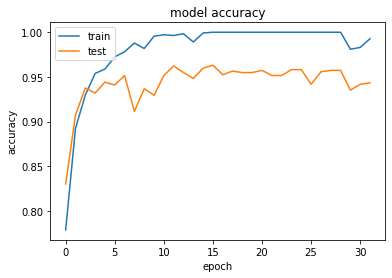

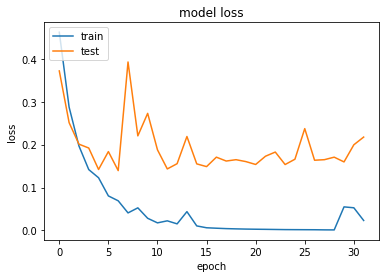

In [ ]:
print(plot.history.keys())
# summarize history for accuracy
plt.plot(plot.history['accuracy'])
plt.plot(plot.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(plot.history['loss'])
plt.plot(plot.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow



cap = cv2.VideoCapture(0)

if cap.isOpened():
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    res=(int(width), int(height))
    # this format fail to play in Chrome/Win10/Colab
    # fourcc = cv2.VideoWriter_fourcc(*'MP4V') #codec
    fourcc = cv2.VideoWriter_fourcc(*'H264') #codec
    out = cv2.VideoWriter('output.mp4', fourcc, 20.0, res)

    frame = None
    while True:
        try:
            is_success, frame = cap.read()
        except cv2.error:
            continue

        if not is_success:
            break

        # OPTIONAL: do some processing

        # convert cv2 BGR format to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        out.write(image)

    out.release() 

    # OPTIONAL: show last image
    if frame:
      cv2_imshow(frame)

cap.release()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const mood = [0,1,2];
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      const pc = Math.floor(Math.random() * mood.length);
      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0); 
      if (pc==0){
      z="Fake"
      }
      else if(pc==1){
      z="Real"
      } 
      else{
      z="No face"
      }
      canvas.getContext('2d').font = "50px Georgia";;
      canvas.getContext('2d').fillText(z, 250, 200);
      
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Webcam test

<IPython.core.display.Javascript object>

Saved to photo.jpg


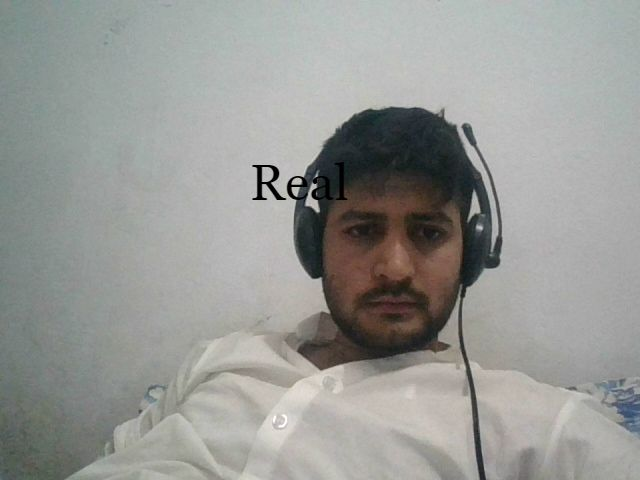

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  print(str(err))